# Training and Saving Final Model

The architecture that yields the highest macro average recall over the different folds is the big tranfer from this [paper](https://arxiv.org/abs/1912.11370). 

In this notebook, we train, evaluate and save the model using the best combination of hyperparameters found in the second notebook.



In [126]:
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path 
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import sys
import json
from tqdm import tqdm



sys.path.append(str(Path.cwd().parent)+'/kymatio_mod')
sys.path.append(str(Path.cwd().parent))
from utils import *

## 1. Hyperparameters

The best combination of hyperparameters is (see image below):

-**number of epochs**: 22

-**batch_size**: 4

-**learning rate**: 0.0031

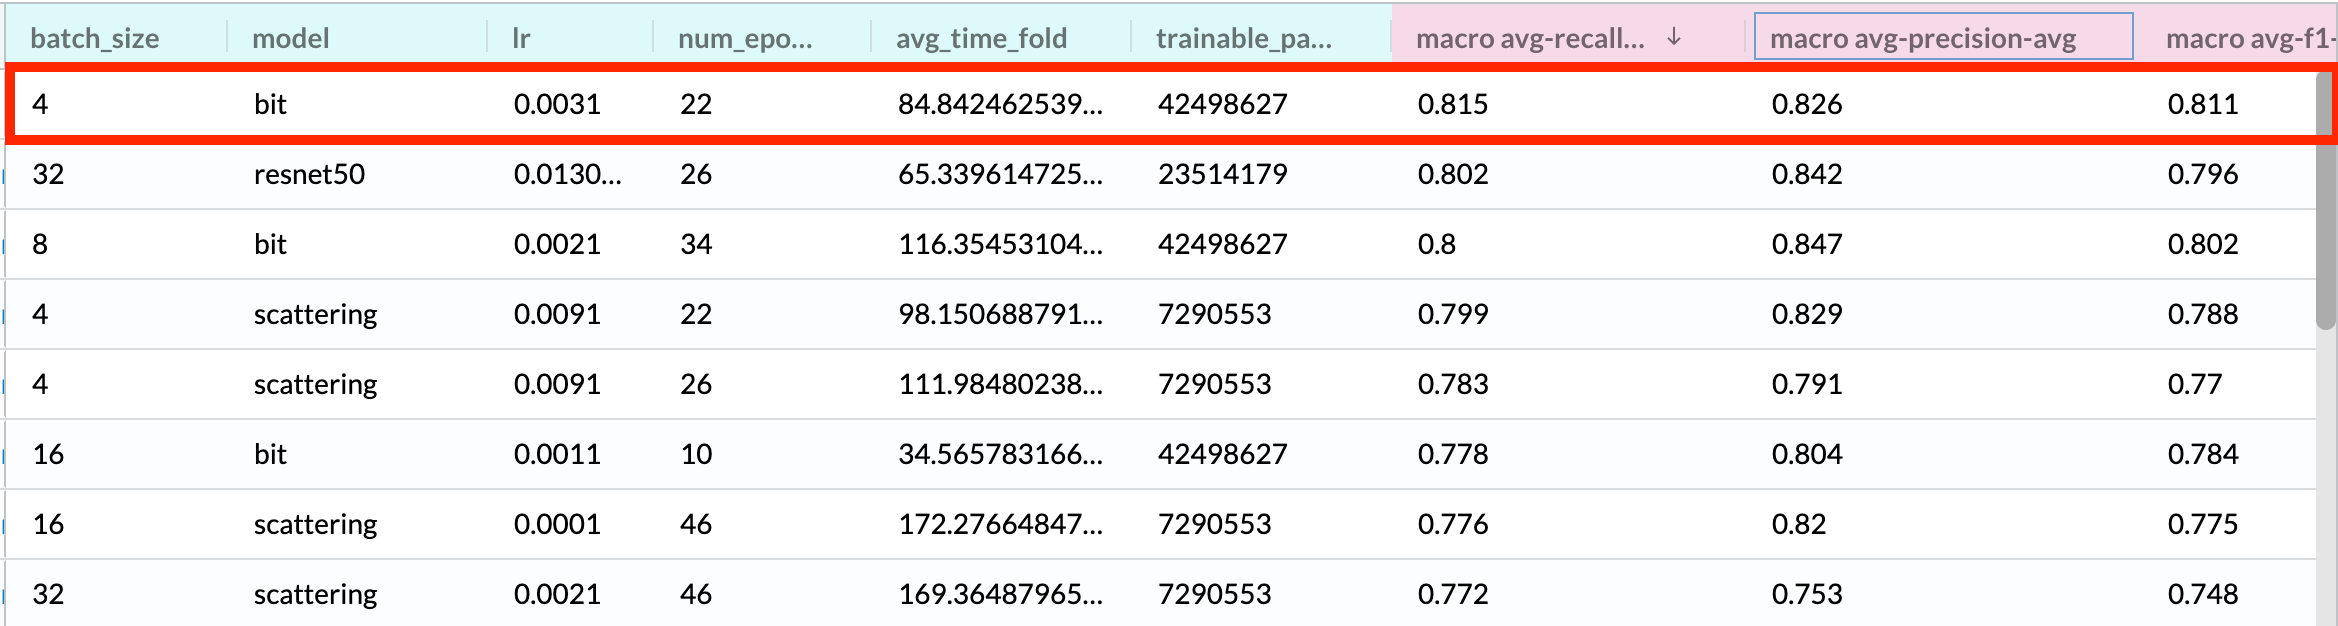

## 2. Split Dataset

Let's split the dataset into training and test sets. 

To do so, we use the StratifiedShuffleSplit from sklearn. 



In [127]:
workers = 4
random_state= 42
batch_size=4
name='bit'
num_epochs=22
lr=0.0031
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
# Create Dataset
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.8, random_state= random_state)
indexes, _ =sss.split(dataset, dataset.targets)
indexes

In [129]:
# save classes
class_names = {}
for i, class_name  in enumerate(dataset.classes):
    class_names[i] = class_name
class_names 

{0: 'acne', 1: 'herpes_simplex', 2: 'lichen_planus'}

In [130]:
# save the name of the classes for inference time
with open('class_names.json', 'w') as fp:
    json.dump(class_names, fp)

## 3. Train Model  

Let's train the model!



In [131]:
network = get_model(name).to(device)

In [132]:
trainloader, testloader, train_subsampler =get_loaders(dataset, indexes[1], indexes[0], batch_size)
loss_function = get_loss_function(dataset, trainloader, train_subsampler.indices, device=device)
optimizer = torch.optim.SGD(network.parameters(), lr=lr)

Epoch 1-- Train Loss:4.895296000299, Test Loss: 2.761460304260254
Epoch 2-- Train Loss:1.439718246459961, Test Loss: 1.002737283706665
Epoch 3-- Train Loss:1.3427253805455708, Test Loss: 1.0334038734436035
Epoch 4-- Train Loss:1.0190169669332958, Test Loss: 1.331728219985962
Epoch 5-- Train Loss:0.9208939281913141, Test Loss: 1.0003795623779297
Epoch 6-- Train Loss:0.715569377743772, Test Loss: 0.5662075877189636
Epoch 7-- Train Loss:0.25162164029288325, Test Loss: 1.0584995746612549
Epoch 8-- Train Loss:0.17738889534735963, Test Loss: 0.1610025018453598
Epoch 9-- Train Loss:0.037317075625261556, Test Loss: 1.0365301370620728
Epoch 10-- Train Loss:0.17467913211328864, Test Loss: 0.24003741145133972
Epoch 11-- Train Loss:0.016054366433222424, Test Loss: 0.22422166168689728
Epoch 12-- Train Loss:0.00436552309145641, Test Loss: 0.23526950180530548
Epoch 13-- Train Loss:0.0038721912146900735, Test Loss: 0.1753704994916916
Epoch 14-- Train Loss:0.0020047271599261357, Test Loss: 0.1993884891

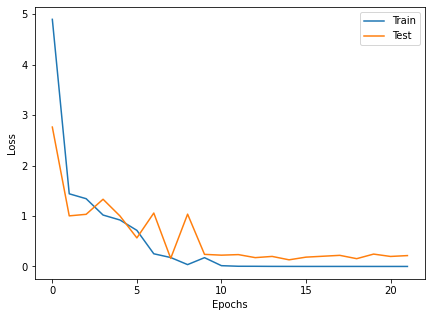

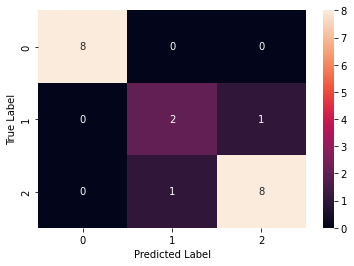

In [133]:
train_loss = []
test_loss= []
for epoch in range(0, num_epochs):
    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        m = nn.Softmax(dim=1)
        loss = loss_function(outputs, targets)  
        loss.backward()   
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    train_loss.append(current_loss/(i+1))
    loss, y_pred, y_true = evaluate_model(network,testloader, loss_function, device)
    test_loss.append(loss.item())
    print(f'Epoch {epoch+1}-- Train Loss:{current_loss/(i+1)}, Test Loss: {loss}')

visualize_loss(train_loss, test_loss) 
get_confusion_matrix(y_true, y_pred)

## 4. Evaluate Model

Now, that we have trained the mode, we need to evaluate the model on the test set and print the classification report.

In [134]:
network.eval()
with torch.no_grad():
    y_pred, y_true, losses, probs= [], [], [], []
    first = True
    for _, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = network(inputs)
        loss = loss_function(outputs, targets)  
        _, predicted = torch.max(outputs.data, 1)
        prob = torch.max(m(outputs), dim=1).values
        # softmax
        # prob
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())
        losses.append(loss.cpu().numpy())
        probs.extend(prob.cpu().numpy())
        if first:
            images = inputs
            first= False
        else:
            images = torch.cat((images, inputs), dim=0)
print(f'Test Loss: {np.array(losses).mean()}')

Test Loss: 0.17363981902599335


In [135]:
print(classification_report(y_true, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.75      1.00      0.86         3
           2       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.92      0.96      0.93        20
weighted avg       0.96      0.95      0.95        20



## 5. Save Model

We now save the state_dict() of the model for inference.


In [136]:
torch.save(network.state_dict(), 'trained_models/bit.pth')

## 6. Visualize Misclassified Images

Here, we visualize all the misclassified images.

Since the images were normalized during training, we need to unnormalize them to visualize them properly.

The images were normalized per channel by:

mean: [0.6475, 0.4907, 0.4165]
std: [0.1875, 0.1598, 0.1460]


In [141]:
unorm = UnNormalize(mean=(0.6475, 0.4907, 0.4165), std=(0.1875, 0.1598, 0.1460))

In [138]:
# create a data frame
df = pd.DataFrame(list(zip(y_pred, y_true, np.arange(0, len(y_pred)), probs)), columns =['pred', 'label', 'index', 'prob'])  
df.head(7)

,pred,label,index,prob
0,0,0,0,0.999976
1,2,2,1,0.925018
2,0,0,2,0.996927
3,2,2,3,0.956235
4,1,1,4,0.866478
5,2,2,5,0.999989
6,1,1,6,0.999112


In [139]:
# find misclassified images
df_misclassify = df[df['pred']!=df['label']]
df_misclassify

,pred,label,index,prob
19,1,2,19,0.652215


Label: lichen_planus, Prediction: herpes_simplex, Probability: 0.652214765548706


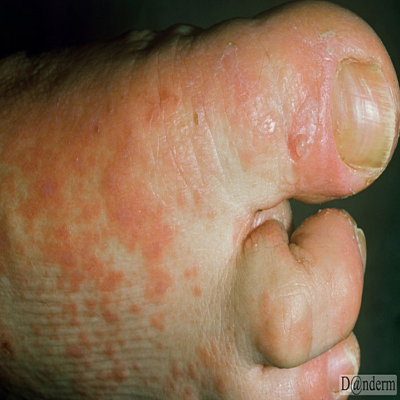

In [140]:
trans = transforms.ToPILImage()
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))
for i, index in enumerate(df_misclassify['index'].values):
    img= trans(unorm(images[index]))
    #img= trans(images[index])
    print(f"Label: {class_names[df_misclassify.iloc[i]['label']]}, Prediction: {class_names[df_misclassify.iloc[i]['pred']]}, Probability: {df_misclassify.iloc[i]['prob']}")
    display(img)